<a href="https://colab.research.google.com/github/Jithesh02/music-genere-classification/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from librosa import feature
import librosa.display as lplt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, AveragePooling2D
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
audio_path = '/content/drive/MyDrive/genres_original/disco/disco.0000.wav'
y, sr = librosa.load(audio_path)
spect = feature.melspectrogram(y=y, hop_length=1024)
mel_spect = librosa.power_to_db(spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: ignored

In [ ]:
fit = StandardScaler()

def audio_features(file_path):
    y, sr = librosa.load(file_path)
    mel_spect = feature.melspectrogram(y=y, hop_length=1024)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    
    if(mel_spect.shape[1] > 645):
        mel_spect = mel_spect[:, :645]
    
    # Scaling the features
    mel_scaled = fit.fit_transform(mel_spect)    
    
    # Shape the data
    mel_shaped = np.reshape(mel_scaled, (mel_spect.shape[0], mel_spect.shape[1], 1))
    return mel_shaped

In [ ]:
map_target = {
    'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6,
    'pop': 7, 'reggae': 8, 'rock': 9
}

In [ ]:
target = []
features = []

root_dir = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "genres_original")
genres = os.listdir(root_dir)

for genre in genres:
    path = os.path.join(root_dir, genre)
    print(f'Reading {genre} Genre...')
    
    # Get list of files for a genre
    files = os.listdir(path)
    for file in files:
        file_path = os.path.join(path, file)
        try:
            data = audio_features(file_path)
            features.append(data)
            target.append(map_target[genre])
        except:
            pass

In [ ]:
features = np.array(features)
target = np.array(target)

In [ ]:
features.shape

(999, 128, 645, 1)

In [ ]:
target.shape

(999,)

In [ ]:
target = to_categorical(target)
target.shape

(999, 10)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=45)

In [ ]:
X_train.shape

(799, 128, 645, 1)

In [ ]:
X_test.shape

(200, 128, 645, 1)

In [ ]:
Y_train.shape

(799, 10)

In [ ]:
Y_test.shape

(200, 10)

## Model Preparation

In [ ]:
#Define Architecture
model = Sequential()

#Convolutional layers
model.add(Conv2D(100, (3, 3), input_shape = (128, 645, 1), activation = "relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(100, (3, 3), activation = "relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(100, (3, 3), activation = "relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(100, (3, 3), activation = "relu"))
model.add(AveragePooling2D((2, 2)))

#Dense layers
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(10, activation = "softmax"))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 126, 643, 100)     1000      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 321, 100)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 61, 319, 100)      90100     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 159, 100)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 157, 100)      90100     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 78, 100)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 12, 76, 100)      

In [ ]:
#Compile the model
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
#Fit the model (or) train the model
model.fit(X_train, Y_train, epochs = 20, validation_data=(X_test, Y_test))

In [ ]:
def plot_validate(history):
    print("Validation Accuracy", max(history.history["val_accuracy"])*100)
    pd.DataFrame(history.history).plot(figsize=(12, 6))

Validation Accuracy 68.00000071525574


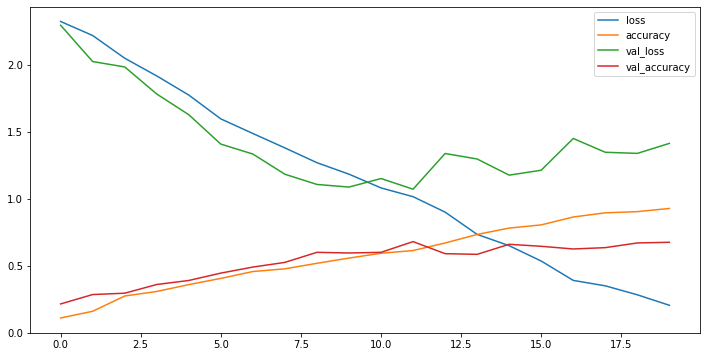

In [ ]:
plot_validate(model.history)

### Classification Report

In [ ]:
pred = model.predict(X_test)

In [ ]:
pred

array([[1.2671193e-06, 3.1713618e-09, 4.7540271e-07, ..., 6.6798293e-07,
        4.9142822e-05, 1.3646579e-04],
       [2.8046337e-04, 9.9089462e-03, 9.2729622e-01, ..., 9.4650667e-03,
        1.0141551e-02, 1.3159353e-02],
       [1.1972599e-03, 1.2172029e-04, 9.9675788e-04, ..., 1.1774109e-06,
        2.4886185e-05, 4.9426337e-05],
       ...,
       [8.9462490e-05, 8.6166918e-02, 3.9105102e-01, ..., 4.5202950e-01,
        2.4195014e-02, 1.5694866e-02],
       [3.9138127e-02, 1.7909626e-02, 4.5694247e-02, ..., 4.8750624e-02,
        4.8745882e-02, 3.6468008e-01],
       [6.0795160e-04, 5.8789586e-04, 1.1032900e-01, ..., 5.1842928e-01,
        2.9017735e-01, 1.8061141e-02]], dtype=float32)

In [ ]:
Y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
Y_pred, test = [], []

for i in range(len(pred)):
    Y_pred.append(np.argmax(pred[i]))
    test.append(np.argmax(Y_test[i]))
    
Y_pred = np.array(Y_pred)
Y_test = np.array(test)

In [ ]:
Y_pred

array([3, 2, 5, 9, 9, 1, 2, 6, 0, 8, 4, 2, 2, 5, 7, 2, 4, 3, 8, 8, 7, 5,
       6, 4, 4, 6, 7, 3, 7, 4, 7, 2, 0, 3, 9, 3, 3, 7, 7, 4, 6, 5, 6, 2,
       2, 3, 8, 1, 3, 1, 2, 4, 4, 1, 7, 1, 5, 4, 4, 5, 4, 5, 1, 1, 9, 1,
       7, 8, 7, 2, 2, 4, 3, 9, 4, 4, 9, 8, 2, 7, 5, 9, 4, 7, 1, 8, 3, 3,
       3, 3, 6, 2, 3, 7, 0, 4, 3, 0, 1, 3, 9, 6, 8, 8, 6, 0, 6, 4, 5, 5,
       6, 4, 1, 2, 8, 0, 3, 9, 5, 5, 6, 6, 5, 5, 4, 0, 1, 1, 6, 8, 4, 6,
       1, 8, 3, 1, 3, 4, 6, 8, 9, 0, 7, 3, 3, 8, 1, 2, 4, 3, 5, 1, 6, 8,
       8, 2, 8, 5, 3, 4, 9, 3, 7, 0, 7, 5, 3, 0, 1, 7, 6, 6, 6, 0, 1, 3,
       8, 1, 3, 9, 9, 6, 4, 1, 0, 3, 9, 2, 1, 1, 5, 7, 4, 9, 1, 3, 1, 7,
       3, 7], dtype=int64)

In [ ]:
acc = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred, average="weighted")
print('Accuracy: ', "%.2f" % (acc*100))
print('F1: ', "%.2f" % (f1*100))

Accuracy:  67.50
F1:  67.17


In [ ]:
cm = confusion_matrix(Y_test, Y_pred)
cr = classification_report(Y_test, Y_pred)

In [ ]:
print("Confusion Matrix: \n", cm)
print("\n")
print("Classification Report: \n", cr)

Confusion Matrix: 
 [[ 8  1  4  3  0  1  0  0  2  2]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 0  1 11  2  0  1  0  2  1  4]
 [ 0  1  0 12  5  0  0  1  1  1]
 [ 0  0  0  1 16  0  0  0  1  0]
 [ 0  1  2  0  0 16  0  0  1  1]
 [ 0  0  0  0  1  0 20  0  0  1]
 [ 0  1  0  1  1  0  0 16  1  0]
 [ 4  0  0  9  1  0  0  0 10  0]
 [ 0  0  0  2  1  0  0  1  1  6]]


Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.38      0.48        21
           1       0.80      1.00      0.89        20
           2       0.65      0.50      0.56        22
           3       0.40      0.57      0.47        21
           4       0.64      0.89      0.74        18
           5       0.89      0.76      0.82        21
           6       1.00      0.91      0.95        22
           7       0.80      0.80      0.80        20
           8       0.56      0.42      0.48        24
           9       0.40      0.55      0.46        11

    accuracy              

In [ ]:
labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(69.0, 0.5, 'Actual Values')

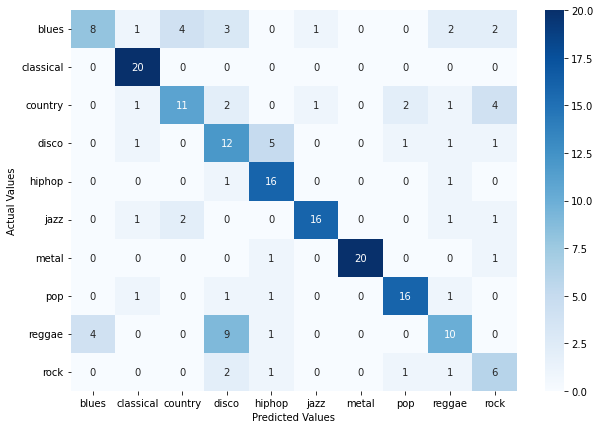

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,cmap="Blues",xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

### Saving Model

In [ ]:
print("Model started saving...")
model.save("Music_Genre_Classifier_cnn", save_format='tf')
print("Model saved successfully...")

Model started saving...
INFO:tensorflow:Assets written to: Music_Genre_Classifier_cnn\assets
Model saved successfully...
